Classifying Pneumonia From Chest X-Rays Using a CNN

# Imports

In [19]:
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, AveragePooling2D, Flatten, Dense, Dropout, BatchNormalization
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau, ModelCheckpoint

import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import classification_report, confusion_matrix
import os # gets the data directory

tf.keras.backend.clear_session() # Clear previous models from memory

np.random.seed(42)
tf.random.set_seed(42)

# Loading Chest X-Ray Images (Pneumonia) Dataset

In [20]:
# Configure dataset paths
BASE_DIR = 'chest_xray'
TRAIN_DIR = os.path.join(BASE_DIR, 'train')
VAL_DIR = os.path.join(BASE_DIR, 'val')
TEST_DIR = os.path.join(BASE_DIR, 'test')

# Image parameters
IMG_HEIGHT = 150  # experiment with 150, 224, or 256
IMG_WIDTH = 150
BATCH_SIZE = 32
NUM_CLASSES = 2  # normal and pneumonia

# Check if directories exist
print("Checking dataset directories...")
for dir_path in [TRAIN_DIR, VAL_DIR, TEST_DIR]:
    if os.path.exists(dir_path):
        print(f"✓ Found: {dir_path}")
        classes = [d for d in os.listdir(dir_path) if os.path.isdir(os.path.join(dir_path, d))]
        print(f"  Classes: {classes}")
    else:
        print(f"✗ Missing: {dir_path} - Please check your path!")

Checking dataset directories...
✓ Found: chest_xray\train
  Classes: ['NORMAL', 'PNEUMONIA']
✓ Found: chest_xray\val
  Classes: ['NORMAL', 'PNEUMONIA']
✓ Found: chest_xray\test
  Classes: ['NORMAL', 'PNEUMONIA']


# Data Preprocessing & Augmentation

Data augmentation helps prevent overfitting by creating variations of training images.

In [21]:
# Data augmentation for training set (helps prevent overfitting)
train_datagen = ImageDataGenerator(
    rescale=1./255,              # Normalize pixel values to [0,1]
    rotation_range=15,           # Randomly rotate images up to 15 degrees
    width_shift_range=0.1,       # Shift horizontally
    height_shift_range=0.1,      # Shift vertically
    shear_range=0.1,             # Shear transformation
    zoom_range=0.1,              # Zoom in/out
    horizontal_flip=True,        # Random horizontal flip
    fill_mode='nearest'
)

# Only rescaling for validation/test sets (NO augmentation)
val_test_datagen = ImageDataGenerator(rescale=1./255)

# Create data generators
train_generator = train_datagen.flow_from_directory(
    TRAIN_DIR,
    target_size=(IMG_HEIGHT, IMG_WIDTH),
    batch_size=BATCH_SIZE,
    class_mode='binary',  # For 2 classes (binary classification)
    shuffle=True
)

val_generator = val_test_datagen.flow_from_directory(
    VAL_DIR,
    target_size=(IMG_HEIGHT, IMG_WIDTH),
    batch_size=BATCH_SIZE,
    class_mode='binary',
    shuffle=False
)

test_generator = val_test_datagen.flow_from_directory(
    TEST_DIR,
    target_size=(IMG_HEIGHT, IMG_WIDTH),
    batch_size=BATCH_SIZE,
    class_mode='binary',
    shuffle=False
)

print(f"\n{'='*50}")
print(f"Dataset Summary:")
print(f"{'='*50}")
print(f"Class indices: {train_generator.class_indices}")
print(f"Training samples: {train_generator.samples}")
print(f"Validation samples: {val_generator.samples}")
print(f"Test samples: {test_generator.samples}")
print(f"{'='*50}")

Found 5216 images belonging to 2 classes.
Found 16 images belonging to 2 classes.
Found 624 images belonging to 2 classes.

Dataset Summary:
Class indices: {'NORMAL': 0, 'PNEUMONIA': 1}
Training samples: 5216
Validation samples: 16
Test samples: 624


# Visualize Sample Images

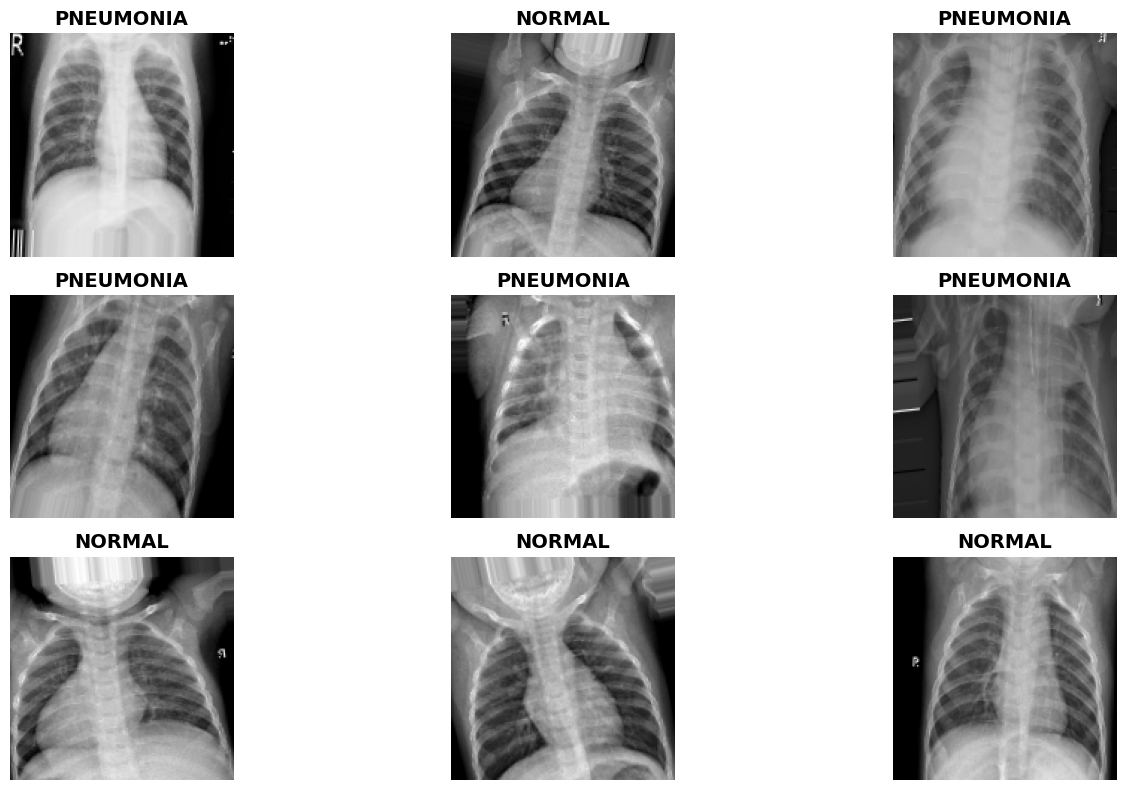

In [22]:
# Visualize sample images from training set
class_names = list(train_generator.class_indices.keys())

plt.figure(figsize=(15, 8))
sample_images, sample_labels = next(train_generator)

for i in range(min(9, len(sample_images))):
    plt.subplot(3, 3, i + 1)
    plt.imshow(sample_images[i], cmap='gray')
    label_idx = int(sample_labels[i])
    plt.title(f'{class_names[label_idx]}', fontsize=14, fontweight='bold')
    plt.axis('off')

plt.tight_layout()
plt.show()

# Build CNN Model

Creating a Convolutional Neural Network for binary classification (Normal vs Pneumonia).

In [23]:
def build_cnn_model(input_shape=(IMG_HEIGHT, IMG_WIDTH, 3)):
    # Uses a hybrid approach with both MaxPooling and AveragePooling layers
    model = Sequential([
        # ----- Block 1 -----
        Conv2D(32, (3,3), padding='same', activation='relu', input_shape=input_shape),
        BatchNormalization(),
        MaxPooling2D(pool_size=(2,2)),
        Dropout(0.1),

        # ----- Block 2 -----
        Conv2D(64, (3,3), padding='same', activation='relu'),
        BatchNormalization(),
        MaxPooling2D(pool_size=(2,2)),
        Dropout(0.15),

        # ----- Block 3 -----
        Conv2D(128, (3,3), padding='same', activation='relu'),
        BatchNormalization(),
        AveragePooling2D(pool_size=(2,2)),
        Dropout(0.25),

        # ----- Block 4 -----
        Conv2D(128, (3,3), padding='same', activation='relu'),
        BatchNormalization(),
        AveragePooling2D(pool_size=(2,2)),
        Dropout(0.25),

        # ----- Flatten and Dense -----
        Flatten(),
        Dense(256, activation='relu'),
        BatchNormalization(),
        Dropout(0.5),

        # ----- Output Layer -----
        Dense(1, activation='sigmoid')  # binary classification
    ])

    return model

# Build the model
model = build_cnn_model()
print("Model created!")

Model created!


c:\Users\Light\Desktop\College\CECS-456-Project\venv\Lib\site-packages\keras\src\layers\convolutional\base_conv.py:113: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


In [24]:
# Display model architecture
model.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                 │ (None, 150, 150, 32)   │           896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization             │ (None, 150, 150, 32)   │           128 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d (MaxPooling2D)    │ (None, 75, 75, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 75, 75, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (None, 75, 75, 64)     │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_1           │ (None, 75, 75, 64)     │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_1 (MaxPooling2D)  │ (None, 37, 37, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 37, 37, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_2 (Conv2D)               │ (None, 37, 37, 128)    │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_2           │ (None, 37, 37, 128)    │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ average_pooling2d               │ (None, 18, 18, 128)    │             0 │
│ (AveragePooling2D)              │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_2 (Dropout)             │ (None, 18, 18, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_3 (Conv2D)               │ (None, 18, 18, 128)    │       147,584 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_3           │ (None, 18, 18, 128)    │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ average_pooling2d_1             │ (None, 9, 9, 128)      │             0 │
│ (AveragePooling2D)              │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_3 (Dropout)             │ (None, 9, 9, 128)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 10368)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 256)            │     2,654,464 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_4           │ (None, 256)            │         1,024 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_4 (Dropout)             │ (None, 256)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 1)              │           257 │
└─────────────────────────────────┴────────────────────────┴─────────────

 Total params: 2,897,985 (11.05 MB)

 Trainable params: 2,896,769 (11.05 MB)

 Non-trainable params: 1,216 (4.75 KB)

In [25]:
# Compile the model
model.compile(
    optimizer='adam',
    loss='binary_crossentropy',  # For binary classification
    metrics=['accuracy', 
             tf.keras.metrics.Precision(name='precision'), 
             tf.keras.metrics.Recall(name='recall')]
)

print("Model compiled!")

Model compiled!


# Setup Callbacks

Callbacks help improve training by:
- **EarlyStopping**: Stop if validation loss doesn't improve
- **ReduceLROnPlateau**: Lower learning rate when stuck
- **ModelCheckpoint**: Save the best model

In [26]:
callbacks = [
    # Stop training if validation loss doesn't improve
    EarlyStopping(
        monitor='val_loss',
        patience=5,
        restore_best_weights=True,
    ),
    
    # Reduce learning rate when stuck
    ReduceLROnPlateau(
        monitor='val_loss',
        factor=0.2,
        patience=3,
        min_lr=1e-6,
        verbose=1
    ),
    
    # Save best model
    ModelCheckpoint(
        'Model2_best_pneumonia_model.h5',
        monitor='val_accuracy',
        save_best_only=True,
        verbose=1
    )
]

print("Callbacks configured!")

Callbacks configured!


# Train the Model

This will take some time (20-30 minutes depending on your hardware). The model will train for up to 25 epochs, but may stop early if it stops improving.

In [27]:
# Train the model
EPOCHS = 25

print(f"Starting training for up to {EPOCHS} epochs...")
print(f"Training on {train_generator.samples} images")
print(f"Validating on {val_generator.samples} images\n")

history = model.fit(
    train_generator,
    epochs=EPOCHS,
    validation_data=val_generator,
    callbacks=callbacks,
    verbose=1
)

print("\n" + "="*50)
print("Training completed")
print("="*50)

Starting training for up to 25 epochs...
Training on 5216 images
Validating on 16 images

Epoch 1/25
163/163 ━━━━━━━━━━━━━━━━━━━━ 0s 443ms/step - accuracy: 0.8135 - loss: 0.5354 - precision: 0.9408 - recall: 0.7977
Epoch 1: val_accuracy improved from None to 0.50000, saving model to Model2_best_pneumonia_model.h5


163/163 ━━━━━━━━━━━━━━━━━━━━ 75s 446ms/step - accuracy: 0.8725 - loss: 0.3535 - precision: 0.9544 - recall: 0.8699 - val_accuracy: 0.5000 - val_loss: 4.7023 - val_precision: 0.5000 - val_recall: 1.0000 - learning_rate: 0.0010
Epoch 2/25
163/163 ━━━━━━━━━━━━━━━━━━━━ 0s 438ms/step - accuracy: 0.9322 - loss: 0.1817 - precision: 0.9581 - recall: 0.9516
Epoch 2: val_accuracy did not improve from 0.50000
163/163 ━━━━━━━━━━━━━━━━━━━━ 72s 439ms/step - accuracy: 0.9304 - loss: 0.1886 - precision: 0.9547 - recall: 0.9515 - val_accuracy: 0.5000 - val_loss: 5.0827 - val_precision: 0.5000 - val_recall: 1.0000 - learning_rate: 0.0010
Epoch 3/25
163/163 ━━━━━━━━━━━━━━━━━━━━ 0s 440ms/step - accuracy: 0.9240 - loss: 0.1906 - precision: 0.9526 - recall: 0.9442
Epoch 3: val_accuracy did not improve from 0.50000
163/163 ━━━━━━━━━━━━━━━━━━━━ 72s 441ms/step - accuracy: 0.9293 - loss: 0.1818 - precision: 0.9563 - recall: 0.9481 - val_accuracy: 0.5000 - val_loss: 4.1582 - val_precision: 0.5000 - val_recall: 1

163/163 ━━━━━━━━━━━━━━━━━━━━ 74s 453ms/step - accuracy: 0.9381 - loss: 0.1614 - precision: 0.9577 - recall: 0.9590 - val_accuracy: 0.5625 - val_loss: 2.6312 - val_precision: 0.5333 - val_recall: 1.0000 - learning_rate: 0.0010
Epoch 6/25
163/163 ━━━━━━━━━━━━━━━━━━━━ 0s 440ms/step - accuracy: 0.9465 - loss: 0.1386 - precision: 0.9639 - recall: 0.9646
Epoch 6: val_accuracy did not improve from 0.56250
163/163 ━━━━━━━━━━━━━━━━━━━━ 72s 441ms/step - accuracy: 0.9465 - loss: 0.1415 - precision: 0.9620 - recall: 0.9662 - val_accuracy: 0.5000 - val_loss: 8.8257 - val_precision: 0.5000 - val_recall: 1.0000 - learning_rate: 0.0010
Epoch 7/25
163/163 ━━━━━━━━━━━━━━━━━━━━ 0s 433ms/step - accuracy: 0.9417 - loss: 0.1485 - precision: 0.9587 - recall: 0.9638
Epoch 7: val_accuracy did not improve from 0.56250
163/163 ━━━━━━━━━━━━━━━━━━━━ 71s 434ms/step - accuracy: 0.9479 - loss: 0.1359 - precision: 0.9632 - recall: 0.9667 - val_accuracy: 0.4375 - val_loss: 5.4578 - val_precision: 0.0000e+00 - val_recal

163/163 ━━━━━━━━━━━━━━━━━━━━ 79s 485ms/step - accuracy: 0.9618 - loss: 0.1076 - precision: 0.9737 - recall: 0.9750 - val_accuracy: 0.6250 - val_loss: 0.7912 - val_precision: 0.5714 - val_recall: 1.0000 - learning_rate: 2.0000e-04
Epoch 10/25
163/163 ━━━━━━━━━━━━━━━━━━━━ 0s 467ms/step - accuracy: 0.9671 - loss: 0.0949 - precision: 0.9789 - recall: 0.9763
Epoch 10: val_accuracy improved from 0.62500 to 0.75000, saving model to Model2_best_pneumonia_model.h5


163/163 ━━━━━━━━━━━━━━━━━━━━ 76s 468ms/step - accuracy: 0.9630 - loss: 0.1063 - precision: 0.9745 - recall: 0.9757 - val_accuracy: 0.7500 - val_loss: 0.6427 - val_precision: 0.7000 - val_recall: 0.8750 - learning_rate: 2.0000e-04
Epoch 11/25
163/163 ━━━━━━━━━━━━━━━━━━━━ 0s 466ms/step - accuracy: 0.9536 - loss: 0.1214 - precision: 0.9640 - recall: 0.9732
Epoch 11: val_accuracy did not improve from 0.75000
163/163 ━━━━━━━━━━━━━━━━━━━━ 76s 466ms/step - accuracy: 0.9594 - loss: 0.1123 - precision: 0.9722 - recall: 0.9732 - val_accuracy: 0.6875 - val_loss: 0.8224 - val_precision: 0.8000 - val_recall: 0.5000 - learning_rate: 2.0000e-04
Epoch 12/25
163/163 ━━━━━━━━━━━━━━━━━━━━ 0s 469ms/step - accuracy: 0.9662 - loss: 0.0998 - precision: 0.9747 - recall: 0.9798
Epoch 12: val_accuracy did not improve from 0.75000
163/163 ━━━━━━━━━━━━━━━━━━━━ 77s 470ms/step - accuracy: 0.9624 - loss: 0.1113 - precision: 0.9725 - recall: 0.9770 - val_accuracy: 0.5625 - val_loss: 1.2898 - val_precision: 0.5333 - v

# Save the Model

In [48]:
# Save final model
model.save('Model2_pneumonia_cnn_final_model.h5')
print("Model saved as 'Model2_best_pneumonia_model.h5'")

# Save model architecture as JSON
model_json = model.to_json()
with open("Model2_model_architecture.json", "w") as json_file:
    json_file.write(model_json)
print("Model architecture saved as 'Model2_model_architecture.json'")

print("\nKey files created:")
print("  • Model2_best_pneumonia_model.h5 (best model during training)")
print("  • Model2_pneumonia_cnn_final_model.h5 (final model)")
print("  • Model2_model_architecture.json (model structure)")
print("="*60)

Model saved as 'Model2_best_pneumonia_model.h5'
Model architecture saved as 'Model2_model_architecture.json'

Key files created:
  • Model2_best_pneumonia_model.h5 (best model during training)
  • Model2_pneumonia_cnn_final_model.h5 (final model)
  • Model2_model_architecture.json (model structure)


# Visualize Predictions on Test Images

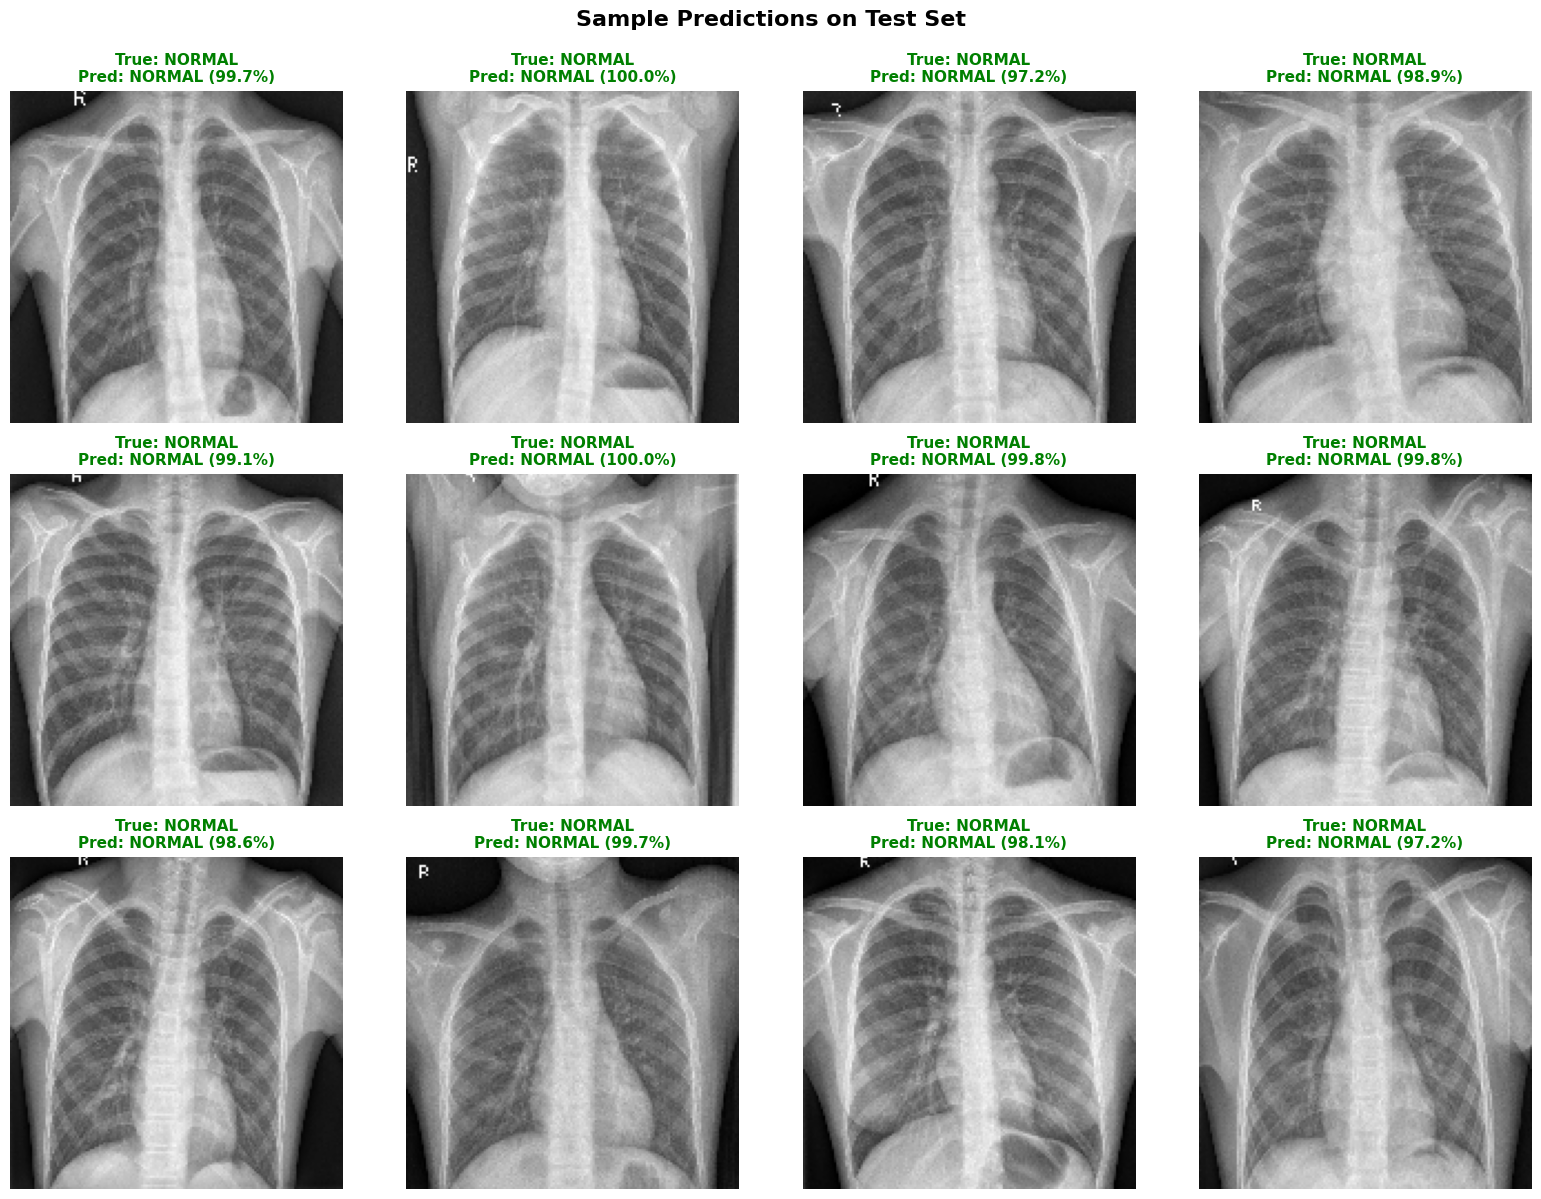

In [49]:
# Visualize some predictions
test_generator.reset()
sample_batch, sample_labels = next(test_generator)
predictions = model.predict(sample_batch, verbose=0)

plt.figure(figsize=(16, 12))
for i in range(min(12, len(sample_batch))):
    plt.subplot(3, 4, i + 1)
    plt.imshow(sample_batch[i], cmap='gray')
    
    true_label = class_names[int(sample_labels[i])]
    pred_prob = predictions[i][0]
    pred_label = class_names[1 if pred_prob > 0.5 else 0]
    confidence = pred_prob if pred_prob > 0.5 else (1 - pred_prob)
    
    color = 'green' if true_label == pred_label else 'red'
    plt.title(f'True: {true_label}\nPred: {pred_label} ({confidence*100:.1f}%)', 
              color=color, fontsize=11, fontweight='bold')
    plt.axis('off')

plt.suptitle('Sample Predictions on Test Set', fontsize=16, fontweight='bold', y=0.995)
plt.tight_layout()
plt.show()

# Confusion Matrix & Classification Report

20/20 ━━━━━━━━━━━━━━━━━━━━ 3s 150ms/step


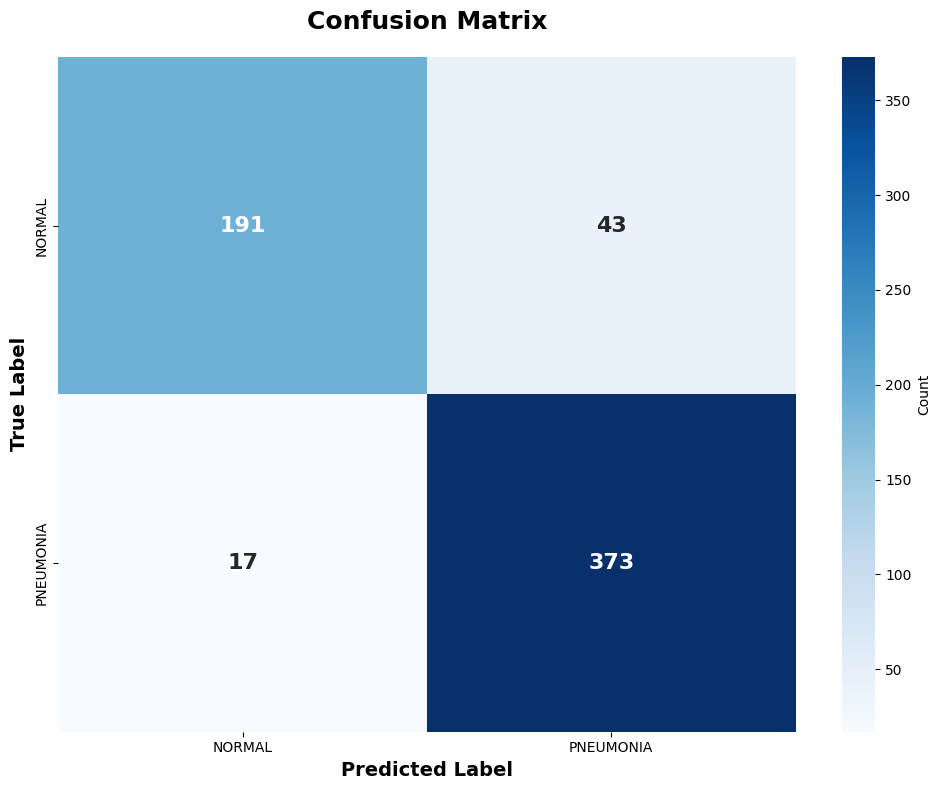


CLASSIFICATION REPORT:
              precision    recall  f1-score   support

      NORMAL     0.9183    0.8162    0.8643       234
   PNEUMONIA     0.8966    0.9564    0.9256       390

    accuracy                         0.9038       624
   macro avg     0.9075    0.8863    0.8949       624
weighted avg     0.9047    0.9038    0.9026       624



In [50]:
# Generate predictions
test_generator.reset()
y_pred_probs = model.predict(test_generator, verbose=1)
y_pred = (y_pred_probs > 0.5).astype(int).flatten()
y_true = test_generator.classes

# Confusion Matrix
cm = confusion_matrix(y_true, y_pred)

plt.figure(figsize=(10, 8))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', 
            xticklabels=class_names, 
            yticklabels=class_names,
            cbar_kws={'label': 'Count'},
            annot_kws={'size': 16, 'weight': 'bold'})
plt.title('Confusion Matrix', fontsize=18, fontweight='bold', pad=20)
plt.ylabel('True Label', fontsize=14, fontweight='bold')
plt.xlabel('Predicted Label', fontsize=14, fontweight='bold')
plt.tight_layout()
plt.show()

# Classification Report
print("\n" + "="*60)
print("CLASSIFICATION REPORT:")
print("="*60)
print(classification_report(y_true, y_pred, target_names=class_names, digits=4))
print("="*60)

# Evaluate on Test Set

In [51]:
# Evaluate model on test data
test_loss, test_acc, test_precision, test_recall = model.evaluate(test_generator)

# Calculate F1 Score
f1_score = 2 * (test_precision * test_recall) / (test_precision + test_recall)

print(f"\n{'='*60}")
print(f"TEST SET RESULTS:")
print(f"{'='*60}")
print(f"Test Accuracy:  {test_acc:.4f} ({test_acc*100:.2f}%)")
print(f"Test Precision: {test_precision:.4f}")
print(f"Test Recall:    {test_recall:.4f}")
print(f"Test F1-Score:  {f1_score:.4f}")
print(f"Test Loss:      {test_loss:.4f}")
print(f"{'='*60}")

20/20 ━━━━━━━━━━━━━━━━━━━━ 3s 150ms/step - accuracy: 0.9038 - loss: 0.2598 - precision: 0.8966 - recall: 0.9564

TEST SET RESULTS:
Test Accuracy:  0.9038 (90.38%)
Test Precision: 0.8966
Test Recall:    0.9564
Test F1-Score:  0.9256
Test Loss:      0.2598


# Visualize training history

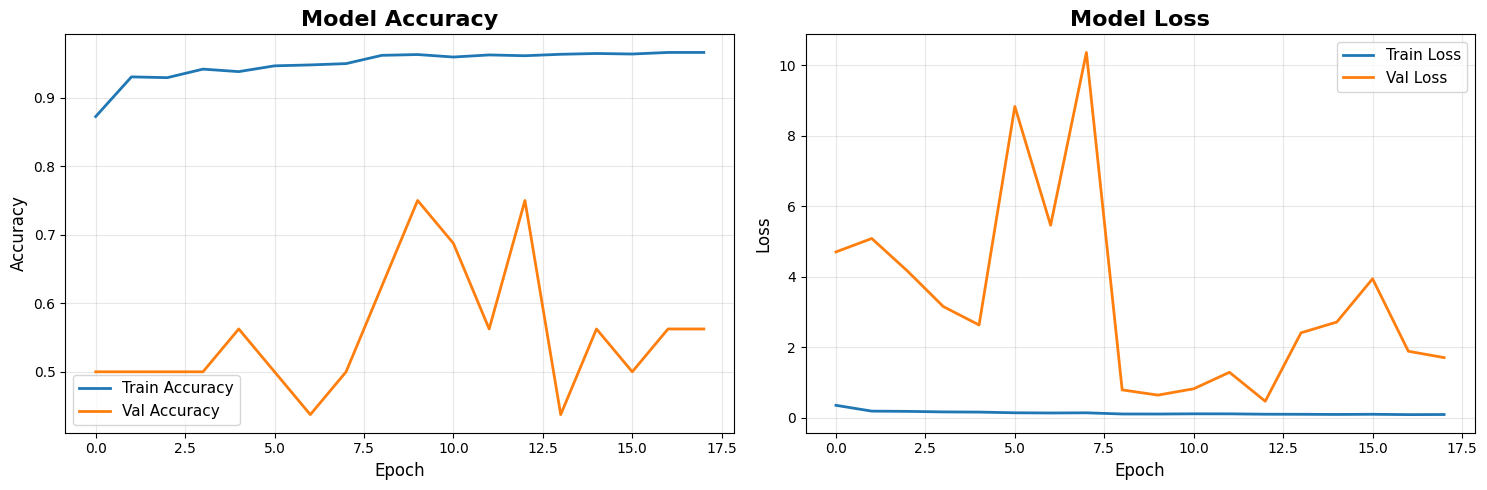

In [52]:
# Plot training history
fig, axes = plt.subplots(1, 2, figsize=(15, 5))

# Accuracy plot
axes[0].plot(history.history['accuracy'], label='Train Accuracy', linewidth=2)
axes[0].plot(history.history['val_accuracy'], label='Val Accuracy', linewidth=2)
axes[0].set_title('Model Accuracy', fontsize=16, fontweight='bold')
axes[0].set_xlabel('Epoch', fontsize=12)
axes[0].set_ylabel('Accuracy', fontsize=12)
axes[0].legend(fontsize=11)
axes[0].grid(True, alpha=0.3)

# Loss plot
axes[1].plot(history.history['loss'], label='Train Loss', linewidth=2)
axes[1].plot(history.history['val_loss'], label='Val Loss', linewidth=2)
axes[1].set_title('Model Loss', fontsize=16, fontweight='bold')
axes[1].set_xlabel('Epoch', fontsize=12)
axes[1].set_ylabel('Loss', fontsize=12)
axes[1].legend(fontsize=11)
axes[1].grid(True, alpha=0.3)

plt.tight_layout()
plt.show()